### Imports

In [1]:
import os
import math

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set()

In [2]:
import mixtureofconcave as subm
import determinantal as logsubm
import plottingtools

---

### A log-submodular function : DPP

In [ ]:
n = 50
m = 200
k = 10

np.random.seed(0)
X = np.random.random((n, m))

K = X @ X.transpose()
ground = np.linalg.det(K)

In [ ]:
S, objectives = logsubm.greedygains_logsubmod(None, X, k)

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plottingtools.objplot(objectives, ground, "mediumvioletred")
plt.subplot(1,2,2)
plottingtools.logobjplot(objectives, ground, "purple", "midnightblue")

In [ ]:
for oo in objectives: print("{:.3f}".format(oo))

---

### A submodular function : a weighted mixture of m(A)^{0.2}

In [ ]:
n = 50
m = 200
k = 10

np.random.seed(0)
X = np.random.random((n, m))
mixw = np.random.random(m); mixw = mixw/np.max(mixw)

ground = np.dot(mixw, np.sum(X, axis=0)**0.2)

In [ ]:
S, objectives = subm.greedygains_submod(None, X, mixw, k)

In [ ]:
plt.figure(figsize=(5,5))
plottingtools.objplot(objectives, ground, "seagreen", "darkolivegreen")

In [ ]:
for oo in objectives: print("{:.3f}".format(oo))

---

### DPP v/s Submodular

In [ ]:
n = 500
m = 72
k = 25

np.random.seed(0)
X = np.random.random((n, m))

np.random.seed(1)
mixw = np.random.random(m); mixw = mixw/np.max(mixw)

In [ ]:
S_d, objectives_d = logsubm.greedygains_logsubmod(None, X, k)

In [ ]:
S_s, objectives_s = subm.greedygains_submod(None, X, mixw, k)

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plottingtools.viztsne(X, S_d, "purple", "DPP", 30)
plt.subplot(1,2,2)
plottingtools.viztsne(X, S_s, "seagreen", "SPP", 30)

---

### Greedy v/s WeightedGreedy

Compare:<br>
Feasibility, output quality, computational complexity.

---

<p style="background-color:#ff9933">
Constrained Submodular Max with Discrete Membership Quota
</p>

#ccff66 #ff99cc #ff9933

Things to look out for:<br>
1. More number of groups <--> more constraint on maximizing w.r.t. one group
2. Having the groups correlating with features <--> making some group sinherently _better_ <--> making the quotas output worser solutions maybe.
3. Try with the _learnt_ ILMSF weights.. that way you have a "true" submodular mixture utility. You could also use true labels!!
4. Alternatively, "assign" groups via clustering.

In [29]:
n_samples = 200
m_features = 2
k_budget = 80

np.random.seed(0)
X = np.random.random((n_samples, m_features))

np.random.seed(1)
mixw = np.random.random(m_features); mixw = mixw/np.max(mixw)

In [30]:
p_groups = 10
memcolors = np.array(["#11{:02X}dd".format(pp) for pp in np.arange(0, 256, 256//p_groups)])

quo = np.ones(p_groups)*2

Random group assignment

In [31]:
np.random.seed(2)
Memvec = np.eye(p_groups)[np.random.choice(p_groups, n_samples)]

print([len(np.argwhere(Memvec[:,jj])) for jj in range(p_groups)])

[17, 22, 18, 17, 18, 28, 23, 17, 24, 16]


Clustering-based group assignment

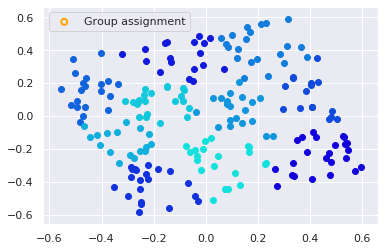

In [32]:
kmeans = KMeans(n_clusters=p_groups, random_state=0).fit(X)
Memvec = np.eye(p_groups)[kmeans.labels_]

#plottingtools.
vizpca_DMQ(X, Memvec, memcolors, [], "orange", "Group assignment", 30)

In [40]:
S_s, objectives_s = subm.greedygains_submod(None, X, mixw, k_budget)
S_sq, objectives_sq = subm.greedyquota_submod(None, X, mixw, Memvec, quo, k_budget)
S_r = np.random.choice(n_samples, k_budget)
objective_sr = subm.submodgains(X, np.sum(X[S_rand,:], axis=0), 0, None, mixw)

print("Objective without quota", S_s)
print("Objective with quota", S_sq)
print("Objective of random selection", S_r)
print(objectives_s[-1], objectives_sq[-1], objective_sr)

Objective without quota [149 135 188  82  74  51 192  10 138   9 150 174  81 114  44   6  19 139
 110 159 167 184  59 104  61 126 179  36  72 132 109  92 136   3 191  71
 125  88  58  55 163 186 143 137  54  22  35  78  11 112   0  96   5 140
  13 182 177  68 180 190  18 196   4  73  60 197  97 111 144  67  53  75
  70 128  15  93   1  57 131 129]
Objective with quota [149 149 188  74  74 135 138 192 150 174  82 114  81  44  51   6  10   9
  19 139 110 159 167 184  59  61 104 126  36 179  72 132 109  92 136   3
 191  71 125  88  58  55 163 186 143 137  54  22  35  78  11 112   0  96
   5 140  13 182 177  68 180 190  18 196   4  73  60 197  97 111 144  67
  53  75  70 128  15  93   1 131]
Objective of random selection [114 160 132  90 181  53  97 108  64  47 168  49 191  12 122  42   3  16
   2  72  25 181  82  39 130  51 178  57  88 111 163  64 126 111  90 129
 199  24 117 144 103  26  52  34  13 156  19 177 119  83 127  71  76  26
 174 127  23 153 116 198  35   4 136   3  57 134 175  

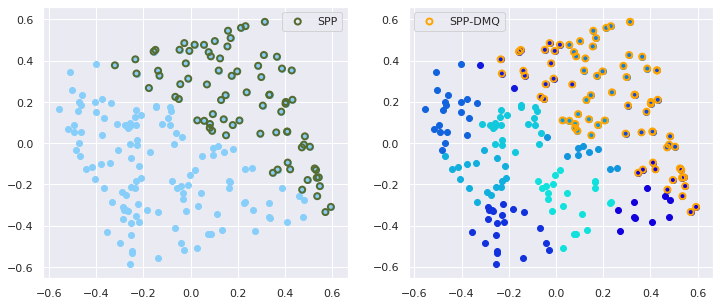

In [41]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
# plottingtools.viztsne(X, S_s, "darkolivegreen", "SPP", 30)
vizpca(X, S_s, "darkolivegreen", "SPP", 30)
plt.subplot(1,2,2)
# plottingtools.viztsne_DMQ(X, Memvec, memcolors, S_sq, "orange", "SPP-DMQ", 30)
vizpca_DMQ(X, Memvec, memcolors, S_sq, "orange", "SPP-DMQ", 30)

In [42]:
Memvec[S_sq]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

In [ ]:
viztsne_IMQ(X, Memvec, ["lightskyblue", "darkcyan"], 3, S_sq, "orange", "SPP-DMQ", 30)

---

In [ ]:
print(objectives_s)
print(objectives_sq)

In [ ]:
def viztsne_IMQ(X, Memvec, memcolors, figrows, S, setcolor, setlabel, perp):
    """ Given an nxm feature matrix X
        A selection of indices S of size k < n
        An n x p Membership matrix for p groups
        Plot the selection's 2d TSNE
    """
    
    [n,m] = X.shape
    p = Memvec.shape[1]
    
    Xemb = TSNE(n_components=2, random_state=256).fit_transform(X)
    
    plt.figure(figsize=((p//figrows+1)*5, figrows*5))
    for jj in range(p):
        plt.subplot(figrows,p//figrows+1,jj+1)
        plt.scatter(Xemb[:,0], Xemb[:,1], c=memcolors[0])
        
        memgrp = np.argwhere(Memvec[:,jj])
        plt.scatter(Xemb[memgrp,0], Xemb[memgrp,1], c=memcolors[1], label="group{}".format(jj+1))
        
        plt.scatter(Xemb[S,0], Xemb[S,1], facecolors="none", edgecolors=setcolor, linewidth=2, label=setlabel)
        plt.legend()